<a href="https://colab.research.google.com/github/DiegoSamanezDenis/COMP472-Brain-Tumor-MRI-CNN/blob/main/notebooks/15c_Classification_MRI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import files
import os

files.upload()

!mkdir -p ~/.kaggle/
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d fernando2rad/brain-tumor-mri-images-44c

!unzip -q brain-tumor-mri-images-44c.zip -d dataset_44c


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/fernando2rad/brain-tumor-mri-images-44c
License(s): Community Data License Agreement - Sharing - Version 1.0
 57% 107M/188M [00:00<00:00, 1.12GB/s]
100% 188M/188M [00:00<00:00, 726MB/s] 


In [4]:
# ── Verify dataset structure ──────────────────────────────────────────
# ImageFolder expects: dataset_44c/<class_name>/*.jpg
# If there's an extra nesting level, adjust DATA_ROOT accordingly.

import pathlib

DATA_ROOT = 'dataset_44c'
top_level = sorted(os.listdir(DATA_ROOT))
print(f'Top-level contents of {DATA_ROOT}/ ({len(top_level)} items):')
for item in top_level[:10]:
    print(f'  {item}/')
if len(top_level) > 10:
    print(f'  ... and {len(top_level) - 10} more')

# If the zip has one wrapper folder, descend into it automatically
if len(top_level) == 1 and os.path.isdir(os.path.join(DATA_ROOT, top_level[0])):
    DATA_ROOT = os.path.join(DATA_ROOT, top_level[0])
    print(f'\n⚠️  Single subfolder detected — using DATA_ROOT = "{DATA_ROOT}"')
    adjusted = sorted(os.listdir(DATA_ROOT))
    print(f'Adjusted contents ({len(adjusted)} items):')
    for item in adjusted[:10]:
        print(f'  {item}/')
    if len(adjusted) > 10:
        print(f'  ... and {len(adjusted) - 10} more')

Top-level contents of dataset_44c/ (44 items):
  Astrocitoma T1/
  Astrocitoma T1C+/
  Astrocitoma T2/
  Carcinoma T1/
  Carcinoma T1C+/
  Carcinoma T2/
  Ependimoma T1/
  Ependimoma T1C+/
  Ependimoma T2/
  Ganglioglioma T1/
  ... and 34 more


In [5]:
from google.colab import drive
drive.mount('/content/drive')

SAVE_DIR = '/content/drive/MyDrive/brain_tumor_weights'
os.makedirs(SAVE_DIR, exist_ok=True)
print(f'Weights will be saved to: {SAVE_DIR}')

Mounted at /content/drive
Weights will be saved to: /content/drive/MyDrive/brain_tumor_weights


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import copy
import time
import json
import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


In [7]:
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.05, 0.05)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

eval_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

## Dataset Splitting
We load the dataset twice (one per transform set) so that `Subset`
inherits the correct transforms for train vs. val/test.

In [8]:
def get_stratified_split_indices(targets, val_split=0.15, test_split=0.15):
  train_idx, temp_idx = train_test_split(
      np.arange(len(targets)),
      test_size=(val_split + test_split),
      stratify=targets,
      random_state=42
  )
  temp_targets = [targets[i] for i in temp_idx]
  val_idx, test_idx = train_test_split(
      temp_idx,
      test_size=test_split / (val_split + test_split),
      stratify=temp_targets,
      random_state=42
  )
  return train_idx, val_idx, test_idx

In [9]:
# Two ImageFolder instances — same images, different transforms
ds_train_aug = datasets.ImageFolder(DATA_ROOT, transform=train_transforms)
ds_eval      = datasets.ImageFolder(DATA_ROOT, transform=eval_transforms)

train_idx, val_idx, test_idx = get_stratified_split_indices(ds_eval.targets)

In [10]:
# Build subsets with correct transforms
train_set = Subset(ds_train_aug, train_idx)   # augmented
val_set   = Subset(ds_eval,      val_idx)     # clean
test_set  = Subset(ds_eval,      test_idx)    # clean

In [11]:
NUM_CLASSES = len(ds_eval.classes)
CLASS_NAMES = ds_eval.classes

print(f'Classes ({NUM_CLASSES}): {CLASS_NAMES}')
print(f'Total images : {len(ds_eval)}')
print(f'Train / Val / Test : {len(train_set)} / {len(val_set)} / {len(test_set)}')


Classes (44): ['Astrocitoma T1', 'Astrocitoma T1C+', 'Astrocitoma T2', 'Carcinoma T1', 'Carcinoma T1C+', 'Carcinoma T2', 'Ependimoma T1', 'Ependimoma T1C+', 'Ependimoma T2', 'Ganglioglioma T1', 'Ganglioglioma T1C+', 'Ganglioglioma T2', 'Germinoma T1', 'Germinoma T1C+', 'Germinoma T2', 'Glioblastoma T1', 'Glioblastoma T1C+', 'Glioblastoma T2', 'Granuloma T1', 'Granuloma T1C+', 'Granuloma T2', 'Meduloblastoma T1', 'Meduloblastoma T1C+', 'Meduloblastoma T2', 'Meningioma T1', 'Meningioma T1C+', 'Meningioma T2', 'Neurocitoma T1', 'Neurocitoma T1C+', 'Neurocitoma T2', 'Oligodendroglioma T1', 'Oligodendroglioma T1C+', 'Oligodendroglioma T2', 'Papiloma T1', 'Papiloma T1C+', 'Papiloma T2', 'Schwannoma T1', 'Schwannoma T1C+', 'Schwannoma T2', 'Tuberculoma T1', 'Tuberculoma T1C+', 'Tuberculoma T2', '_NORMAL T1', '_NORMAL T2']
Total images : 4479
Train / Val / Test : 3135 / 672 / 672


In [12]:
NUM_WORKERS = 2  # safe default for Colab

train_loader = DataLoader(train_set, batch_size=32, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_set,   batch_size=32, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_set,  batch_size=32, shuffle=False,
                          num_workers=NUM_WORKERS, pin_memory=True)

dataloaders = {'train': train_loader, 'val': val_loader}

# Training & Evaluation Pipeline

In [13]:
def train_model(model, criterion, optimizer, scheduler, dataloaders, device,
                num_epochs=25, save_path=None):
    """
    Train with validation, LR scheduling, history tracking, and best-weight saving.

    Args:
        scheduler: LR scheduler (stepped per epoch on val loss)
        dataloaders: dict with 'train' and 'val' keys
        save_path: .pth path to save best weights (also saves _history.json)
    Returns:
        model (best weights loaded), history dict
    """
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': [],
        'lr': []
    }

    since = time.time()

    for epoch in range(num_epochs):
        current_lr = optimizer.param_groups[0]['lr']
        history['lr'].append(current_lr)
        print(f'Epoch {epoch + 1}/{num_epochs}  (lr={current_lr:.2e})')
        print('-' * 45)

        for phase in ['train', 'val']:
            model.train() if phase == 'train' else model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(dataloaders[phase], desc=f'  {phase}', leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc  = (running_corrects.double() / len(dataloaders[phase].dataset)).item()

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc)

            print(f'  {phase:5s}  Loss: {epoch_loss:.4f}  Acc: {epoch_acc:.4f}')

            if phase == 'val':
                # Step the scheduler on validation loss
                scheduler.step(epoch_loss)

                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    if save_path:
                        torch.save(best_model_wts, save_path)
                        print(f'  ✓ New best model saved ({save_path})')
        print()

    elapsed = time.time() - since
    print(f'Training complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)

    if save_path:
        history_path = save_path.replace('.pth', '_history.json')
        with open(history_path, 'w') as f:
            json.dump(history, f)
        print(f'History saved to {history_path}')

    return model, history

In [14]:
def evaluate_model(model, test_loader, class_names, device):
    """Run evaluation on test set. Returns confusion matrix, labels, preds."""
    model = model.to(device).eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print('\nClassification Report:')
    print(classification_report(all_labels, all_preds,
                                target_names=class_names, zero_division=0))

    cm = confusion_matrix(all_labels, all_preds)
    return cm, all_labels, all_preds

In [15]:
def plot_training_curves(history, title=''):
    """Plot loss, accuracy, and learning rate curves."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)

    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train')
    axes[0].plot(epochs, history['val_loss'],   'r-', label='Validation')
    axes[0].set_title(f'{title} — Loss')
    axes[0].set_xlabel('Epoch'); axes[0].set_ylabel('Loss')
    axes[0].legend(); axes[0].grid(True, alpha=0.3)

    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train')
    axes[1].plot(epochs, history['val_acc'],   'r-', label='Validation')
    axes[1].set_title(f'{title} — Accuracy')
    axes[1].set_xlabel('Epoch'); axes[1].set_ylabel('Accuracy')
    axes[1].legend(); axes[1].grid(True, alpha=0.3)

    if 'lr' in history:
        axes[2].plot(epochs[:len(history['lr'])], history['lr'], 'g-')
        axes[2].set_title(f'{title} — Learning Rate')
        axes[2].set_xlabel('Epoch'); axes[2].set_ylabel('LR')
        axes[2].set_yscale('log'); axes[2].grid(True, alpha=0.3)
    else:
        axes[2].set_visible(False)

    plt.tight_layout()
    plt.show()


def plot_confusion_matrix(cm, class_names, title=''):
    """Plot confusion matrix as a heatmap."""
    fig, ax = plt.subplots(figsize=(max(8, len(class_names) * 0.5),
                                     max(6, len(class_names) * 0.4)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax)
    ax.set_xlabel('Predicted'); ax.set_ylabel('True')
    ax.set_title(f'{title} — Confusion Matrix')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

## Helper: Build model + optimizer + scheduler

In [16]:
def build_experiment(model, lr=1e-3):
    """Return criterion, optimizer, and scheduler for a model."""
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=3
    )
    return criterion, optimizer, scheduler

## Model Definitions
Set `USE_PRETRAINED = True` (recommended) for transfer learning,
or `False` to train from scratch as in the original notebook.

In [17]:
USE_PRETRAINED = False  # ← flip to True for much better results

def _weights(flag):
    """Return pretrained weights arg or None."""
    return 'IMAGENET1K_V1' if flag else None

# ── ResNet18 ──────────────────────────────────────────────────────────
model_resnet = models.resnet18(weights=_weights(USE_PRETRAINED))
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, NUM_CLASSES)
criterion_resnet, optimizer_resnet, scheduler_resnet = build_experiment(model_resnet)
print(f'ResNet18    params: {sum(p.numel() for p in model_resnet.parameters() if p.requires_grad):,}')

# ── MobileNetV2 ──────────────────────────────────────────────────────
model_mobilenet = models.mobilenet_v2(weights=_weights(USE_PRETRAINED))
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.last_channel, NUM_CLASSES)
criterion_mobile, optimizer_mobile, scheduler_mobile = build_experiment(model_mobilenet)
print(f'MobileNetV2 params: {sum(p.numel() for p in model_mobilenet.parameters() if p.requires_grad):,}')

# ── VGG16 ─────────────────────────────────────────────────────────────
model_vgg = models.vgg16(weights=_weights(USE_PRETRAINED))
model_vgg.classifier[6] = nn.Linear(4096, NUM_CLASSES)
criterion_vgg, optimizer_vgg, scheduler_vgg = build_experiment(model_vgg)
print(f'VGG16       params: {sum(p.numel() for p in model_vgg.parameters() if p.requires_grad):,}')


ResNet18    params: 11,199,084
MobileNetV2 params: 2,280,236
VGG16       params: 134,440,812


# Train ResNet18 (Scratch) — 44c

In [76]:
model_resnet, history_resnet = train_model(
    model_resnet, criterion_resnet, optimizer_resnet, scheduler_resnet,
    dataloaders, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'resnet18_44c.pth')
)

Epoch 1/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 3.0402  Acc: 0.2006


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.6469  Acc: 0.2649
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 2/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 2.4101  Acc: 0.3164


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 3.0806  Acc: 0.2455

Epoch 3/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 2.1241  Acc: 0.3901


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.2890  Acc: 0.3676
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 4/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.8620  Acc: 0.4612


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 3.3544  Acc: 0.2530

Epoch 5/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.6276  Acc: 0.5152


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.0449  Acc: 0.4390
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 6/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.4879  Acc: 0.5592


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.5937  Acc: 0.5208
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 7/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.3398  Acc: 0.5933


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.0913  Acc: 0.4196

Epoch 8/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.1829  Acc: 0.6475


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.4077  Acc: 0.5982
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 9/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.0839  Acc: 0.6635


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.5008  Acc: 0.5952

Epoch 10/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.9922  Acc: 0.6915


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.3351  Acc: 0.6101
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 11/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.8923  Acc: 0.7244


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.1527  Acc: 0.6518
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 12/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.8006  Acc: 0.7537


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.5134  Acc: 0.5878

Epoch 13/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.7434  Acc: 0.7687


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.0859  Acc: 0.6905
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 14/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.6975  Acc: 0.7821


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.0777  Acc: 0.6979
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 15/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.6223  Acc: 0.8013


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.2330  Acc: 0.6548

Epoch 16/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.5495  Acc: 0.8274


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.3228  Acc: 0.6384

Epoch 17/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.5114  Acc: 0.8341


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.7644  Acc: 0.7827
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 18/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.4586  Acc: 0.8523


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.7415  Acc: 0.7932
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/resnet18_44c.pth)

Epoch 19/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.3880  Acc: 0.8788


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.8407  Acc: 0.7649

Epoch 20/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.3869  Acc: 0.8804


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.6823  Acc: 0.5074

Training complete in 10m 20s
Best val Acc: 0.7932
History saved to /content/drive/MyDrive/brain_tumor_weights/resnet18_44c_history.json


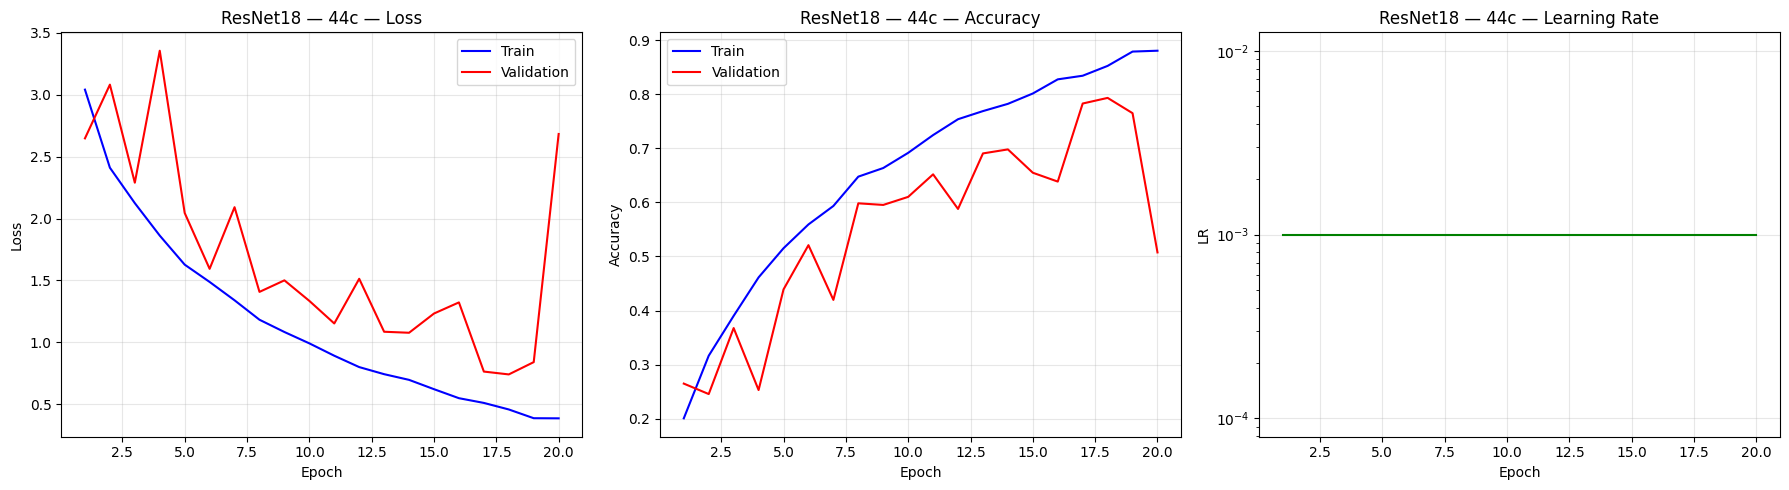

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.95      0.73      0.83        26
      Astrocitoma T1C+       1.00      0.80      0.89        35
        Astrocitoma T2       0.83      0.73      0.78        26
          Carcinoma T1       1.00      0.80      0.89        10
        Carcinoma T1C+       1.00      0.88      0.94        17
          Carcinoma T2       1.00      0.91      0.95        11
         Ependimoma T1       0.67      0.86      0.75         7
       Ependimoma T1C+       0.70      1.00      0.82         7
         Ependimoma T2       0.62      0.62      0.62         8
      Ganglioglioma T1       1.00      0.33      0.50         3
    Ganglioglioma T1C+       1.00      0.33      0.50         3
      Ganglioglioma T2       0.00      0.00      0.00         3
          Germinoma T1       0.00      0.00      0.00         4
        Germinoma T1C+       1.00      0.50      0.67         6
          Germi

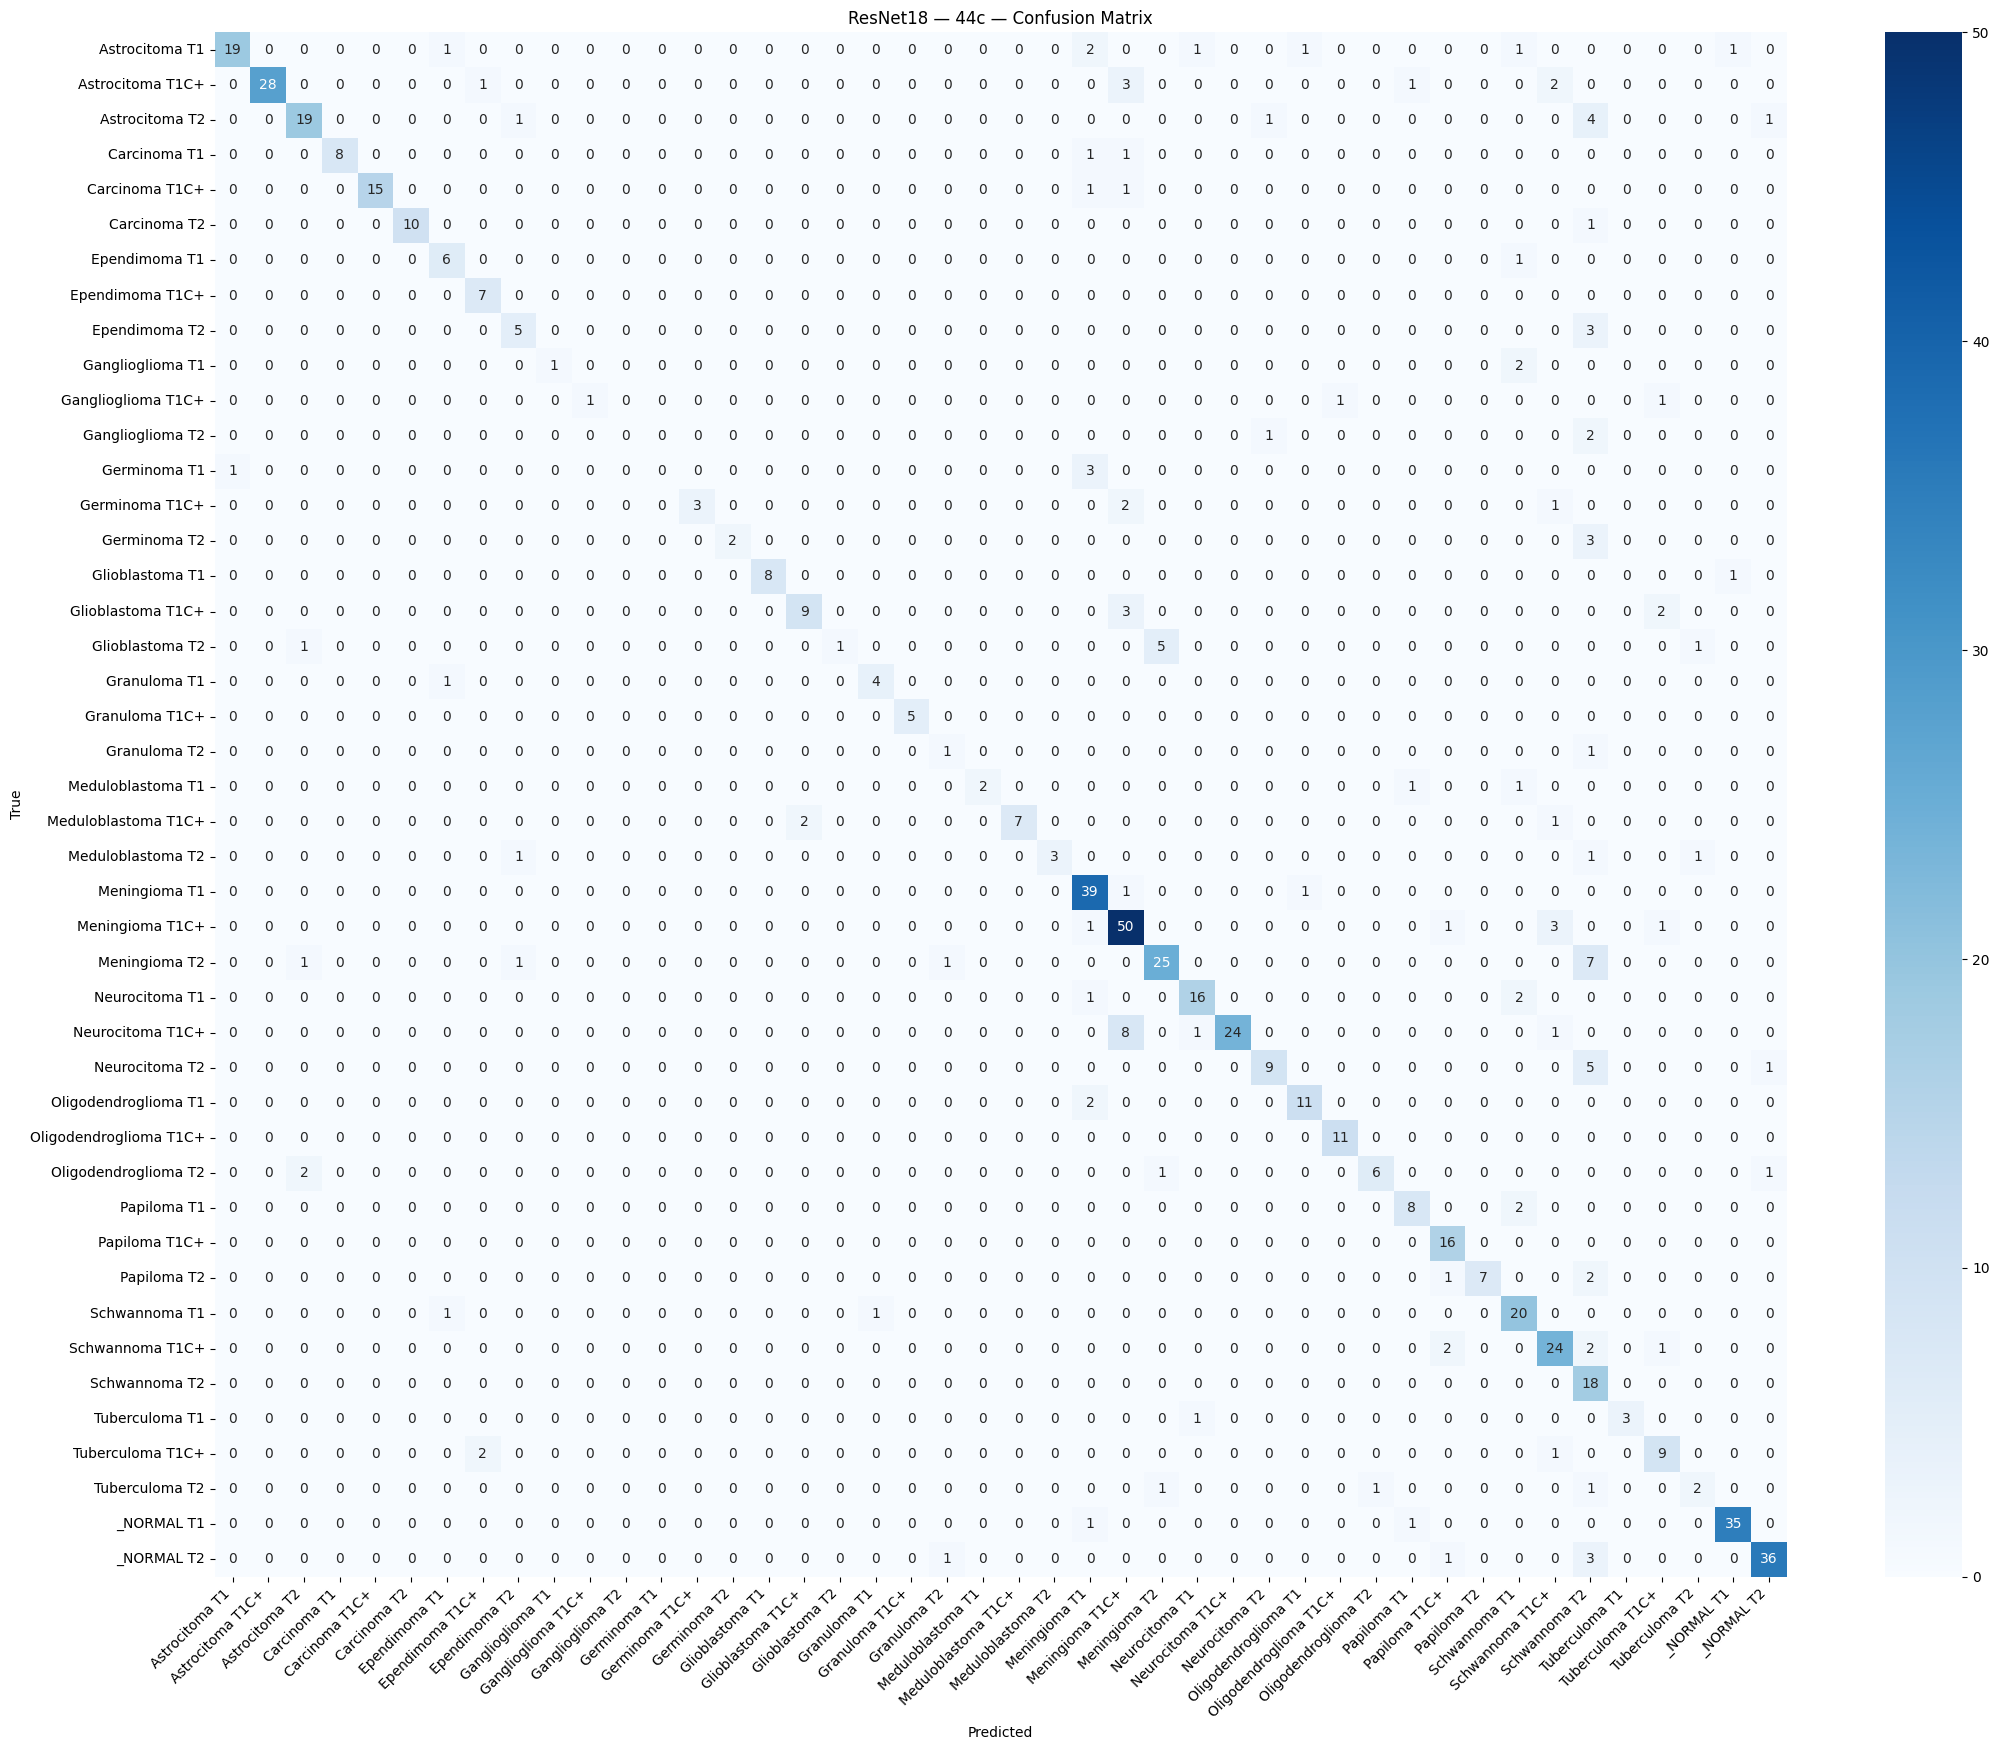

In [77]:
plot_training_curves(history_resnet, title='ResNet18 — 44c')
cm_resnet, _, _ = evaluate_model(model_resnet, test_loader, CLASS_NAMES, device)
plot_confusion_matrix(cm_resnet, CLASS_NAMES, title='ResNet18 — 44c')

# Train MobileNetV2 (Scratch) — 44c

In [78]:
model_mobilenet, history_mobilenet = train_model(
    model_mobilenet, criterion_mobile, optimizer_mobile, scheduler_mobile,
    dataloaders, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'mobilenetv2_44c.pth')
)

Epoch 1/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 3.2751  Acc: 0.1346


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 3.3243  Acc: 0.1548
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 2/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 2.7086  Acc: 0.2421


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.6185  Acc: 0.2515
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 3/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 2.2585  Acc: 0.3426


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.0800  Acc: 0.4018
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 4/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 2.0112  Acc: 0.4099


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.8538  Acc: 0.4643
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 5/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.7808  Acc: 0.4715


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.7595  Acc: 0.4926
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 6/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.5667  Acc: 0.5321


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 2.7763  Acc: 0.3497

Epoch 7/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.4850  Acc: 0.5544


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.6420  Acc: 0.5119
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 8/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.3711  Acc: 0.5834


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.6618  Acc: 0.5089

Epoch 9/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.2513  Acc: 0.6083


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.5962  Acc: 0.5298
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 10/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.1693  Acc: 0.6344


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.6567  Acc: 0.5253

Epoch 11/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 1.0655  Acc: 0.6705


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.1940  Acc: 0.6250
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 12/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.9680  Acc: 0.6986


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.6126  Acc: 0.5521

Epoch 13/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.9029  Acc: 0.7110


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.4136  Acc: 0.5923

Epoch 14/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.8296  Acc: 0.7445


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.9963  Acc: 0.7128
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 15/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.7855  Acc: 0.7528


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.0165  Acc: 0.7068

Epoch 16/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.7083  Acc: 0.7812


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.8715  Acc: 0.7723
  ✓ New best model saved (/content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c.pth)

Epoch 17/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.7059  Acc: 0.7802


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 1.4352  Acc: 0.6399

Epoch 18/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.6085  Acc: 0.8019


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.9946  Acc: 0.7217

Epoch 19/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.5856  Acc: 0.8089


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.7634  Acc: 0.7708

Epoch 20/20  (lr=1.00e-03)
---------------------------------------------


  train:   0%|          | 0/98 [00:00<?, ?it/s]

  train  Loss: 0.5324  Acc: 0.8274


  val:   0%|          | 0/21 [00:00<?, ?it/s]

  val    Loss: 0.9816  Acc: 0.7277

Training complete in 10m 22s
Best val Acc: 0.7723
History saved to /content/drive/MyDrive/brain_tumor_weights/mobilenetv2_44c_history.json


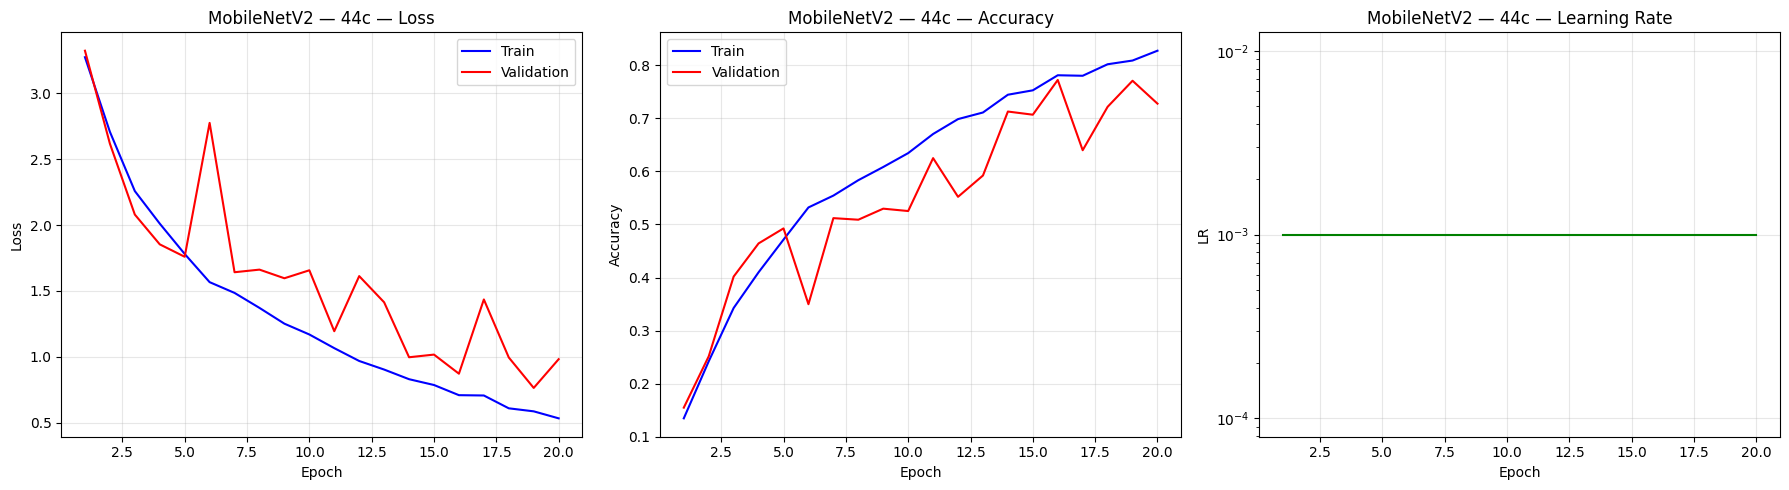

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]


Classification Report:
                        precision    recall  f1-score   support

        Astrocitoma T1       0.71      0.58      0.64        26
      Astrocitoma T1C+       0.87      0.77      0.82        35
        Astrocitoma T2       0.61      0.77      0.68        26
          Carcinoma T1       1.00      0.20      0.33        10
        Carcinoma T1C+       1.00      0.88      0.94        17
          Carcinoma T2       1.00      1.00      1.00        11
         Ependimoma T1       0.30      1.00      0.47         7
       Ependimoma T1C+       0.36      0.71      0.48         7
         Ependimoma T2       0.00      0.00      0.00         8
      Ganglioglioma T1       1.00      0.67      0.80         3
    Ganglioglioma T1C+       1.00      1.00      1.00         3
      Ganglioglioma T2       1.00      0.33      0.50         3
          Germinoma T1       1.00      0.25      0.40         4
        Germinoma T1C+       0.33      0.17      0.22         6
          Germi

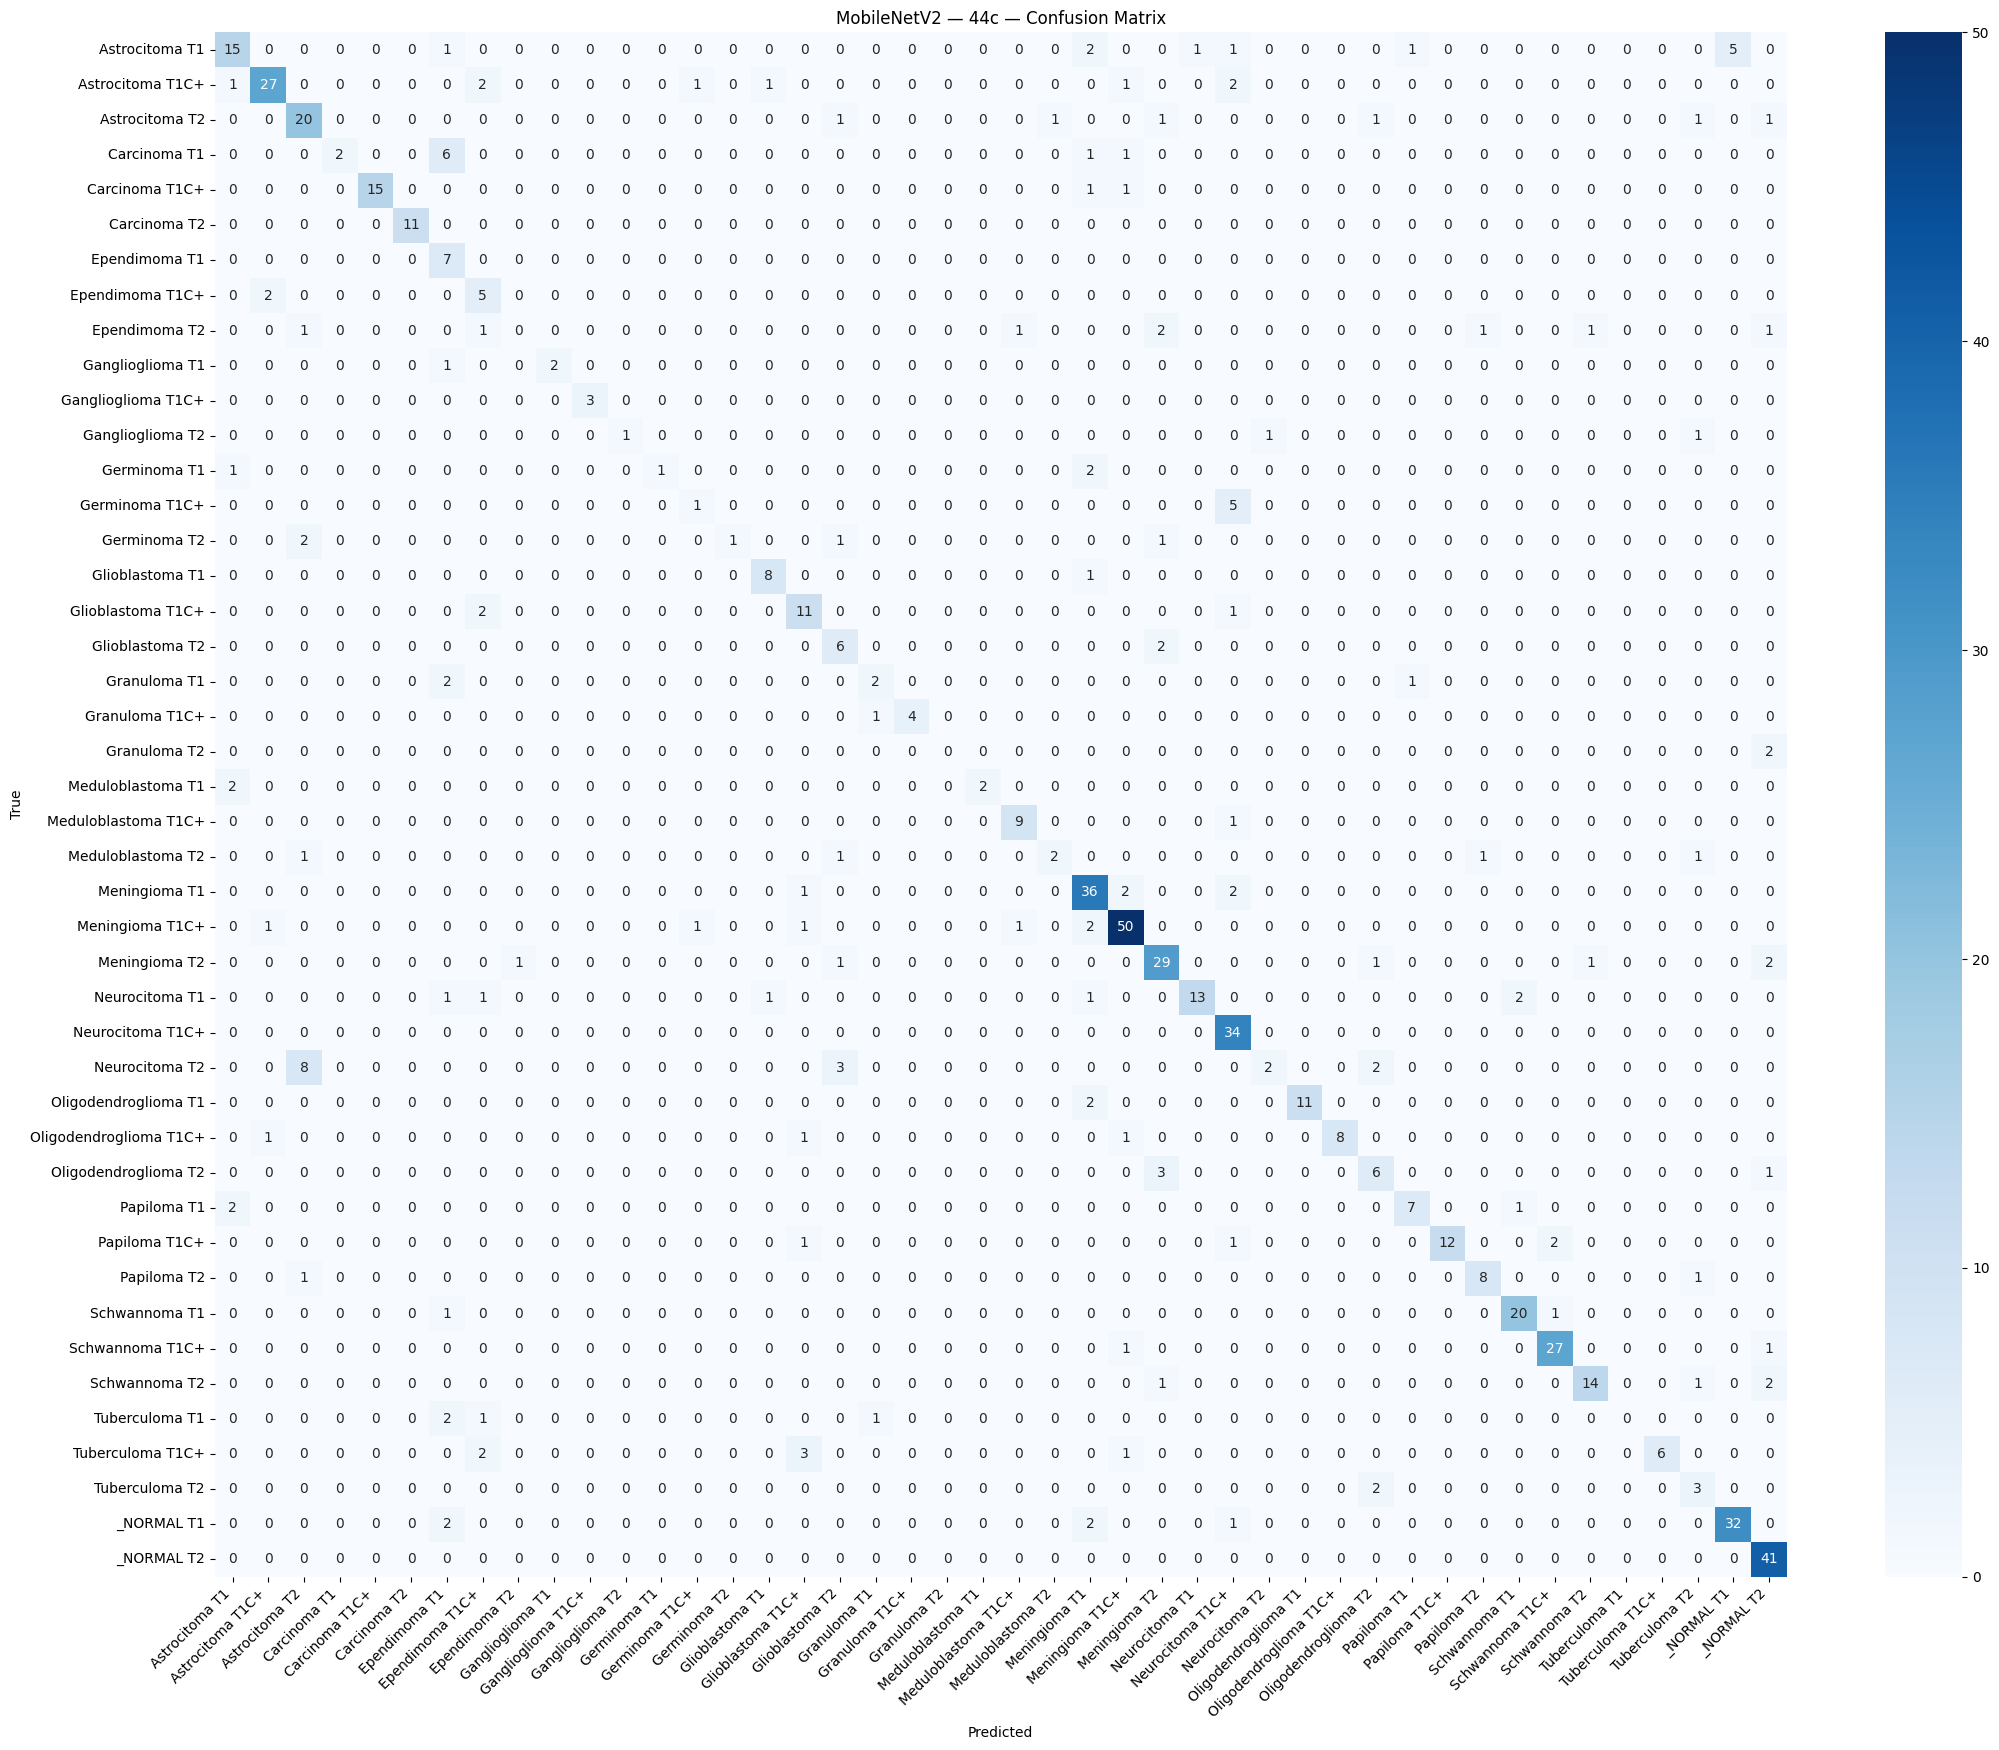

In [79]:
plot_training_curves(history_mobilenet, title='MobileNetV2 — 44c')
cm_mobile, _, _ = evaluate_model(model_mobilenet, test_loader, CLASS_NAMES, device)
plot_confusion_matrix(cm_mobile, CLASS_NAMES, title='MobileNetV2 — 44c')


# Train VGG16 (Scratch) — 44c

In [ ]:
model_vgg, history_vgg = train_model(
    model_vgg, criterion_vgg, optimizer_vgg, scheduler_vgg,
    dataloaders, device,
    num_epochs=20,
    save_path=os.path.join(SAVE_DIR, 'vgg16_44c.pth')
)

In [ ]:
plot_training_curves(history_vgg, title='VGG16 — 44c')
cm_vgg, _, _ = evaluate_model(model_vgg, test_loader, CLASS_NAMES, device)
plot_confusion_matrix(cm_vgg, CLASS_NAMES, title='VGG16 — 44c')

# Reload Saved Model & History (Example)
Use this to reload weights after a runtime restart without retraining.

In [ ]:
# model_reloaded = models.resnet18(weights=None)
# model_reloaded.fc = nn.Linear(model_reloaded.fc.in_features, NUM_CLASSES)
# model_reloaded.load_state_dict(
#     torch.load(os.path.join(SAVE_DIR, 'resnet18_44c.pth'), map_location=device)
# )
# model_reloaded.to(device).eval()
#
# with open(os.path.join(SAVE_DIR, 'resnet18_44c_history.json')) as f:
#     history_reloaded = json.load(f)
# plot_training_curves(history_reloaded, title='ResNet18 — 44c (reloaded)')